# Anime Image Classification using CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'anastasia': [], 'takao': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('anastasia') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['anastasia'].append(np.array(img))
            elif file_name.startswith('takao') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['takao'].append(np.array(img))
    return images

In [3]:
images = load_images_from_zip("data.zip")

In [4]:
print("Number of images of Anastasia:", len(images['anastasia']))
print("Number of images of Takao:", len(images['takao']))

Number of images of Anastasia: 50
Number of images of Takao: 50


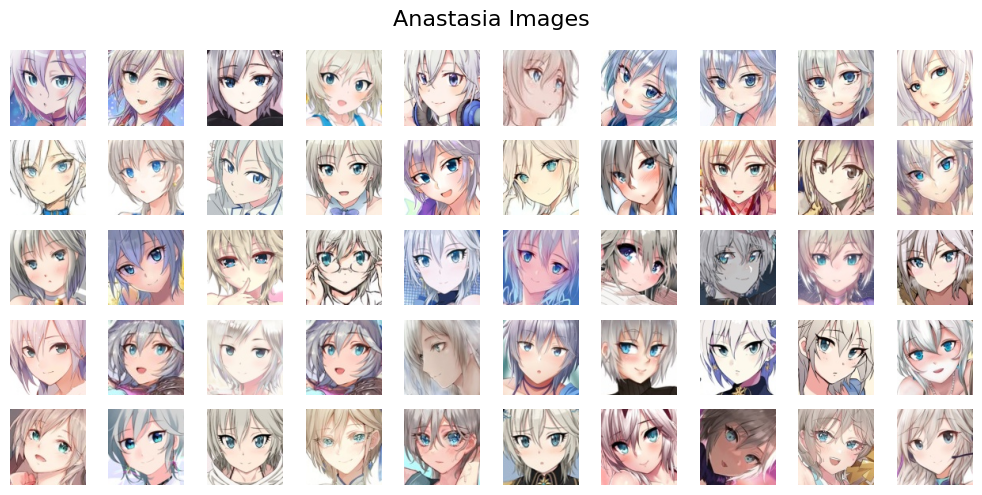

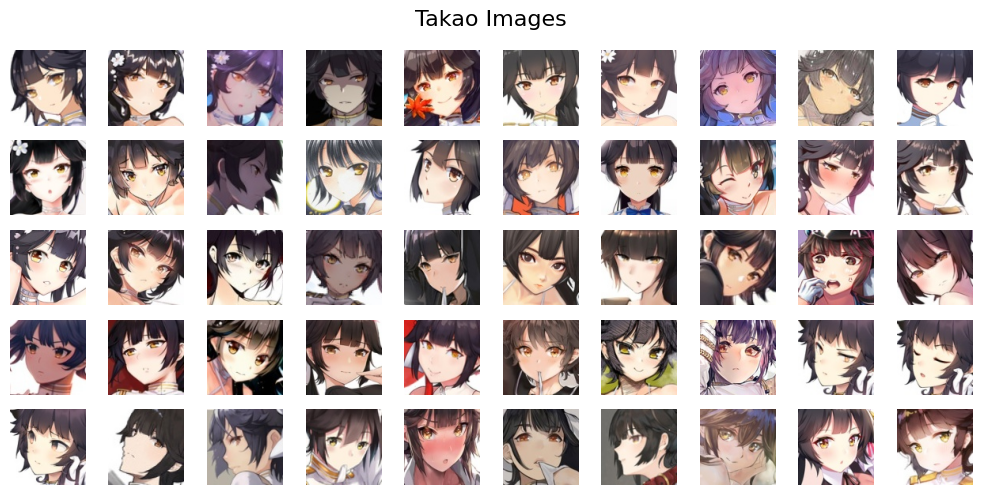

In [5]:
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# anastasia
plot_images(images['anastasia'], 'Anastasia Images')

# takao
plot_images(images['takao'], 'Takao Images')

In [6]:
class AnimeDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes
        
        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# dataset
dataset = AnimeDataset(images, transform=transform, classes=['anastasia', 'takao'])


In [7]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


indices = list(range(len(dataset)))

# indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# DataLoader
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

Train size: 80
Validation size: 20


In [8]:
class AnimeCNN(nn.Module):
    def __init__(self):
        super(AnimeCNN, self).__init__()
        # Adding padding=1 
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# model
model = AnimeCNN()

In [9]:
print(model)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [10]:
input_tensor = torch.randn(1, 3, 64, 64)

def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")


hooks = []
for layer in model.children():
    hook = layer.register_forward_hook(print_size)
    hooks.append(hook)


with torch.no_grad():
    output = model(input_tensor)
print("Final output size:", output.size())


for hook in hooks:
    hook.remove()

Conv2d output size: torch.Size([1, 32, 64, 64])
MaxPool2d output size: torch.Size([1, 32, 32, 32])
Conv2d output size: torch.Size([1, 64, 32, 32])
MaxPool2d output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training 
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')


Epoch 1, Train Loss: 0.7333, Val Loss: 0.1828
Epoch 2, Train Loss: 0.1857, Val Loss: 0.0011
Epoch 3, Train Loss: 0.0471, Val Loss: 0.0005
Epoch 4, Train Loss: 0.0086, Val Loss: 0.0003
Epoch 5, Train Loss: 0.0009, Val Loss: 0.0002
Finished Training


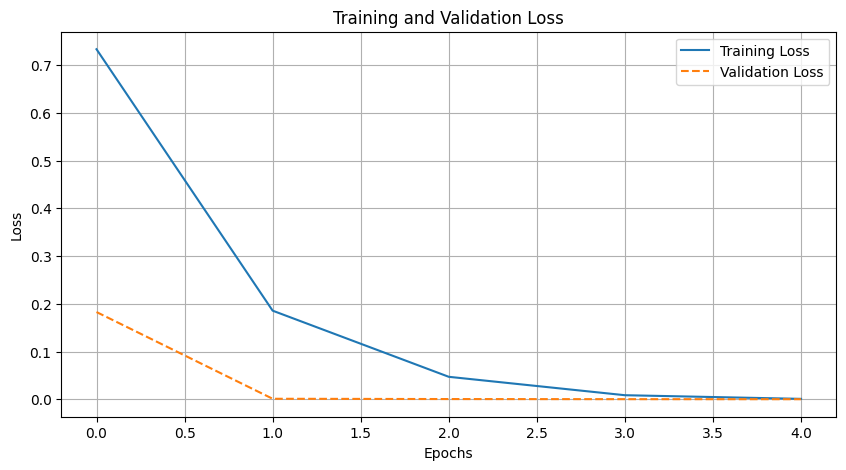

In [13]:
# training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

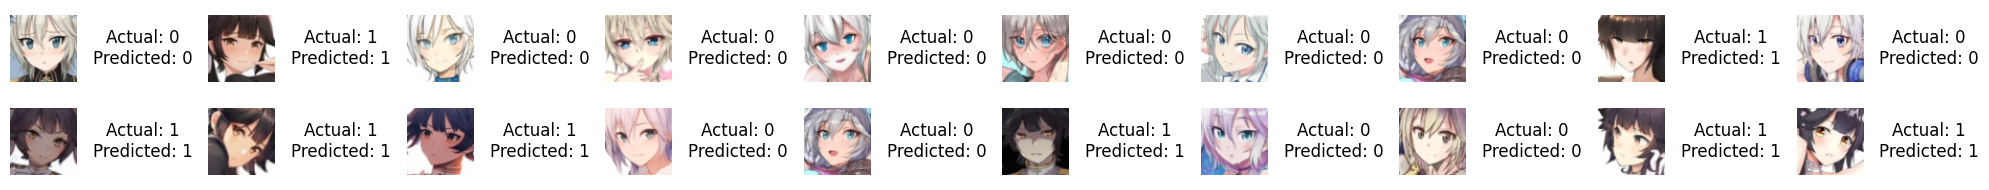

In [14]:
# display image
def imshow(img, ax):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  
    ax.axis('off')


model.eval()

data_iter = iter(val_loader)
images, labels = next(data_iter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)


num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

for idx in range(num_images):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    
    
    imshow(images[idx].cpu(), axs[row, col])
    
    
    axs[row, col + 1].text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}",
                           horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[row, col + 1].axis('off')


for idx in range(num_images, num_rows * num_cols):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    axs[row, col].axis('off')
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

In [15]:
correct = 0
total = 0


with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'correct: {correct}, total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

correct: 20, total: 20
Validation Accuracy: 100.00%


In [16]:
class AnimeCNNModified(nn.Module):
    def __init__(self):
        super(AnimeCNNModified, self).__init__()
        # padding=1 
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  
        x = self.pool(F.leaky_relu(self.conv2(x)))  
        x = x.view(-1, 64 * 16 * 16)
        x = F.leaky_relu(self.fc1(x))  
        x = self.fc2(x)
        return x

Epoch 1, Train Loss: 0.3022, Val Loss: 0.0419
Epoch 2, Train Loss: 0.0891, Val Loss: 0.0156
Epoch 3, Train Loss: 0.0365, Val Loss: 0.0002
Epoch 4, Train Loss: 0.0196, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0029, Val Loss: 0.0003
Epoch 6, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 7, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 8, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 9, Train Loss: 0.0001, Val Loss: 0.0000
Epoch 10, Train Loss: 0.0001, Val Loss: 0.0000
Finished Training


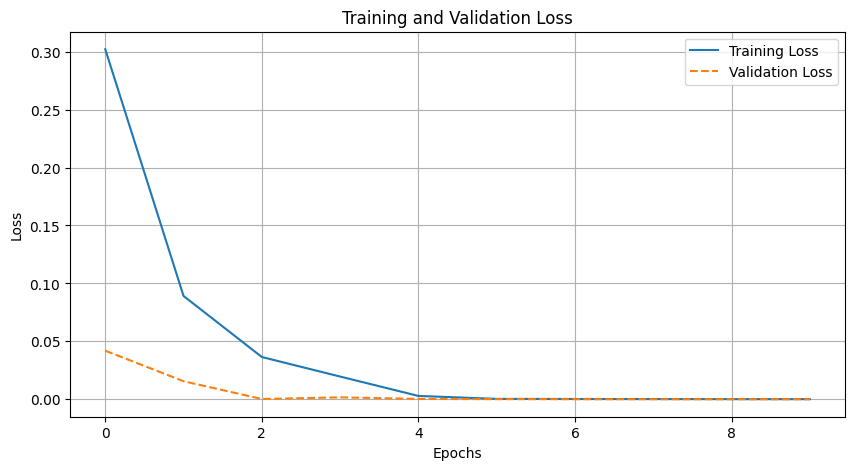

In [17]:
model_new = AnimeCNN()


# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001)

num_epochs = 10 
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_new.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_new(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model_new(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

# training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()